# Deep Learning Assignment - Iris Data Classification
### Student Name: [Yosef Ahmed](https://github.com/yosef13103/)
### Student ID: 2210009123
### Section Number: 9MA1

In [1]:
import sys
import torch

# Print Python Version
print (f"Python Version {sys.version}")

# Check for pytorch version
print(f"PyTorch version: {torch.__version__}")

# Ensuring that device is set to CUDA if available.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Device in use: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Python Version 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
PyTorch version: 2.5.0+cu124
CUDA is available. Device in use: NVIDIA GeForce RTX 3070


## Loading the iris dataset and splitting into training and testing datasets

Training Set: 70%

Validation Set: 15% 

Testing Set: 15% 

Stratified to help ensure class distribtions, hopefully leading to more accurate results after evaulting the model

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_and_clean_iris():
    path = "./data/iris.csv"
    df = pd.read_csv(path)
    df = df.dropna()
    df = df.replace({"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}) # Converting all text to categorical numbers
    return df

# Splitting into training, validation, and testing
def split_data(df):
    x = df.drop(columns=["species"])  # Removing the species column, keeping only the features columns and storing in x
    y = df["species"]  # Storing the species column in y

    # First split: training and testing sets
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

    # Second split: validation and testing sets
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    return x_train, x_val, x_test, y_train, y_val, y_test

def convert_to_tensors(x_train, x_val, x_test, y_train, y_val, y_test): # Convert df to tensors to use in the model
    x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    return x_train_tensor, x_val_tensor, x_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor

# Load and preprocess the data
iris_df = load_and_clean_iris()
x_train, x_val, x_test, y_train, y_val, y_test = split_data(iris_df)

# Convert DataFrames to Tensors
x_train_tensor, x_val_tensor, x_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = convert_to_tensors(x_train, x_val, x_test, y_train, y_val, y_test)

print(x_train_tensor, x_val_tensor, x_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor)

tensor([[5.1000, 2.5000, 3.0000, 1.1000],
        [6.2000, 2.2000, 4.5000, 1.5000],
        [5.1000, 3.8000, 1.5000, 0.3000],
        [6.8000, 3.2000, 5.9000, 2.3000],
        [5.7000, 2.8000, 4.1000, 1.3000],
        [6.7000, 3.0000, 5.2000, 2.3000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [5.1000, 3.8000, 1.6000, 0.2000],
        [4.4000, 2.9000, 1.4000, 0.2000],
        [7.1000, 3.0000, 5.9000, 2.1000],
        [6.5000, 3.2000, 5.1000, 2.0000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [5.0000, 3.0000, 1.6000, 0.2000],
        [6.0000, 2.9000, 4.5000, 1.5000],
        [5.5000, 2.4000, 3.8000, 1.1000],
        [7.2000, 3.2000, 6.0000, 1.8000],
        [5.0000, 3.4000, 1.6000, 0.4000],
        [4.7000, 3.2000, 1.6000, 0.2000],
        [6.7000, 3.3000, 5.7000, 2.5000],
        [5.9000, 3.2000, 4.8000, 1.8000],
        [5.4000, 3.4000, 1.5000, 0.4000],
        [6.3000, 2.7000, 4.9000, 1.8000],
        [7.6000, 3.0000, 6.6000, 2.1000],
        [7.7000, 2.8000, 6.7000, 2

C:\Users\Yosef\AppData\Local\Temp\ipykernel_33852\2578361396.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}) # Converting all text to categorical numbers


# Building the Model
- Using 3 hidden layers with dropout rate of 35% to prevent overfitting
- Using LeakyReLU as it's better than regular ReLU by solving the dying ReLU problem
- Using Batch Normalization since it normalizes the input to each layer helping to speed up the training
- Input size of 4 since there are 4 measurements (sepal_l, sepal_w, petal_l, petal_w)
- Output size of 3 since there are 3 species (Iris-setosa, Iris-versicolor, Iris-virginica)
- 128 neurons in the hidden layers managed to lead to a low count of epochs while keeping accuracy high

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the feedforward neural network class
class IrisNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch norm after first hidden
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Third hidden
        self.bn2 = nn.BatchNorm1d(hidden_size)  # Batch norm after third hidden
        self.fc4 = nn.Linear(hidden_size, output_size)  # Output layer
        self.dropout = nn.Dropout(0.35)  # Dropout layer with 35% dropout rate
        self.softmax = nn.Softmax(dim=1)  # Softmax layer for the output layer

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.bn1(x)  # Apply batch norm after first hidden layer
        x = self.dropout(x)  # Apply dropout after first hidden layer
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.bn2(x)  # Apply batch norm after third hidden layer
        x = self.dropout(x)  # Apply dropout after third hidden layer
        x = self.fc4(x)
        x = self.softmax(x)  # Apply softmax at the end
        return x

In [4]:
# Define the model
input_size = 4  # Number of features (sepal_l, sepal_w, petal_l, petal_w)
hidden_size = 128 # Number of neurons
output_size = 3  # Number of classes (Iris-setosa, Iris-versicolor, Iris-virginica)

model = IrisNN(input_size, hidden_size, output_size)

print(model)

IrisNN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (softmax): Softmax(dim=1)
)


# Training the model
- Using the Adam optimizer since it's the best as far as I am aware of.
- 0.003 helped to initially speed up the training process instead of starting with 0.001. Tried with 0.01 but 

Epoch [10/300], Training Loss: 0.5739, Validation Loss: 0.9792
Epoch [20/300], Training Loss: 0.5670, Validation Loss: 0.7226
Early stopping at epoch 23

Training completed in 0.05 seconds.


c:\Users\Yosef\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


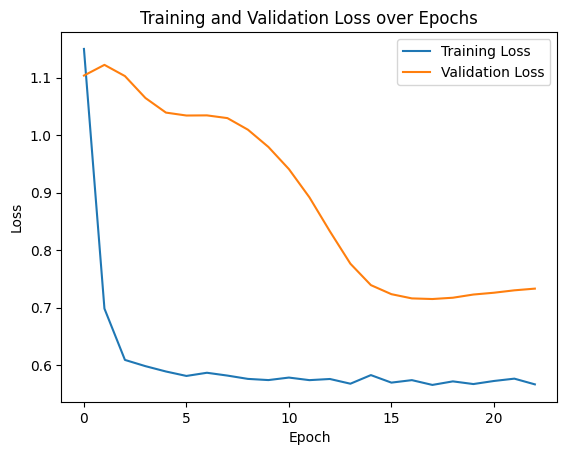

In [5]:
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler_gamma = 0.95 # Initial learning rate is 0.003, and the learning rate will be multiplied by 0.95 after each epoch
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_scheduler_gamma, verbose=True) # Dynamically alter the learning rate during training

# Training the model
num_epochs = 300 # Number of epochs to train the model
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf') # Initialize the best validation loss
patience_counter = 0 # Counter to keep track of the number of epochs with no improvement
final_epoch = 0 # Epoch at which training stops due to early stopping

def train_model(model, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor):
    global best_val_loss, patience_counter, final_epoch
    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        train_loss_values.append(loss.item())

        # Validation checking
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_loss_values.append(val_loss.item())

        if (epoch + 1) % 10 == 0: # print every 10 epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping if the validation loss does not improve for 'patience' epochs
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        final_epoch = epoch + 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {final_epoch}')
            break

    return train_loss_values, val_loss_values

start_time = time.time() # Start training time
train_loss_values, val_loss_values = train_model(model, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor) # Train the model
end_time = time.time() # End training time
training_time = end_time - start_time
print(f'\nTraining completed in {training_time:.2f} seconds.')

# Plot the loss values
plt.plot(range(len(train_loss_values)), train_loss_values, label='Training Loss')
plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


# Testing and Evaluating the Model

The 95.45455% validation accuracy helped me to know that there was less overfitting happening than I could believe having only seen the 100% testing accuracy

In [6]:
# Evaluating the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    # Test set evaluation
    test_outputs = model(x_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_accuracy = (test_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Test Accuracy: {test_accuracy * 100:.5f}%')

    # Validation set evaluation
    val_outputs = model(x_val_tensor)
    _, val_predicted = torch.max(val_outputs.data, 1)
    val_accuracy = (val_predicted == y_val_tensor).sum().item() / y_val_tensor.size(0)
    print(f'Validation Accuracy: {val_accuracy * 100:.5f}%')

Test Accuracy: 91.30435%
Validation Accuracy: 86.36364%


# Analyzing the model


Test Set Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.80      1.00      0.89         8
 Iris-virginica       1.00      0.75      0.86         8

       accuracy                           0.91        23
      macro avg       0.93      0.92      0.92        23
   weighted avg       0.93      0.91      0.91        23


Validation Set Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.88      0.93         8
Iris-versicolor       0.70      1.00      0.82         7
 Iris-virginica       1.00      0.71      0.83         7

       accuracy                           0.86        22
      macro avg       0.90      0.86      0.86        22
   weighted avg       0.90      0.86      0.87        22



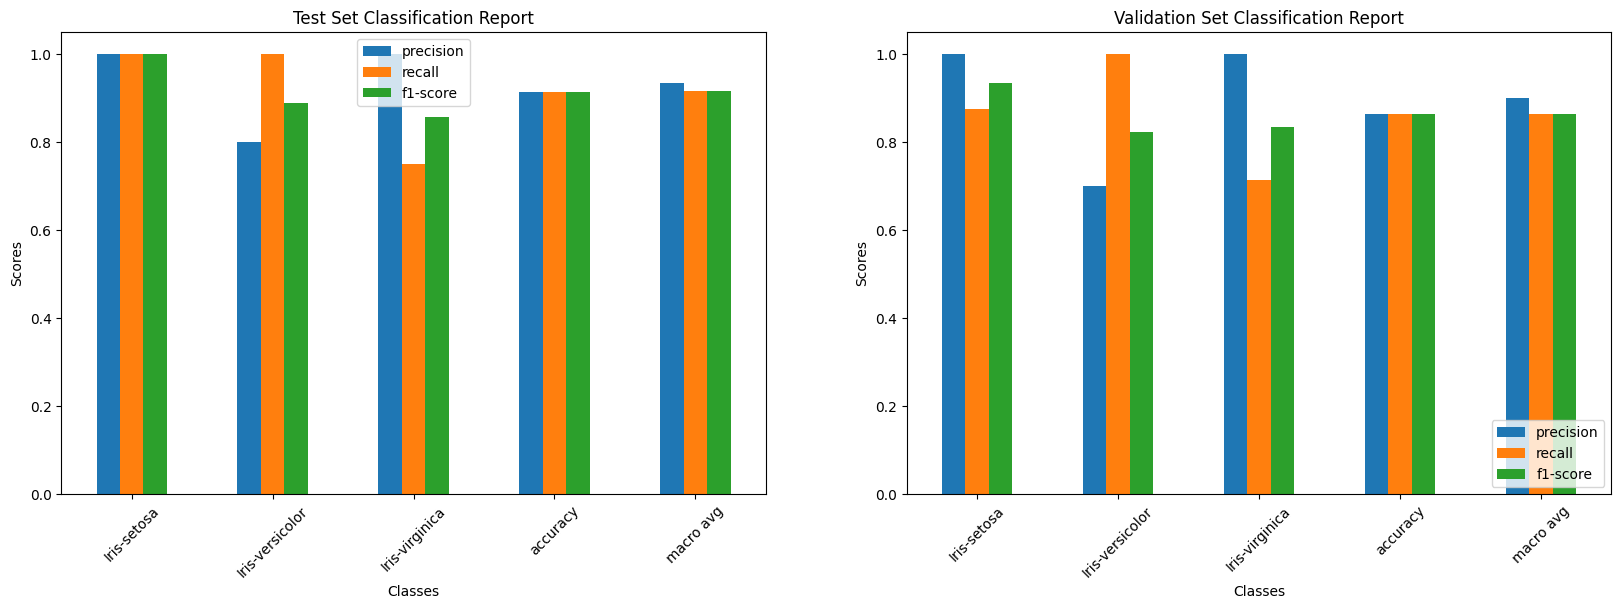


Test Set Confusion Matrix:
                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa                7                0               0
Iris-versicolor            0                8               0
Iris-virginica             0                2               6

Validation Set Confusion Matrix:
                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa                7                1               0
Iris-versicolor            0                7               0
Iris-virginica             0                2               5


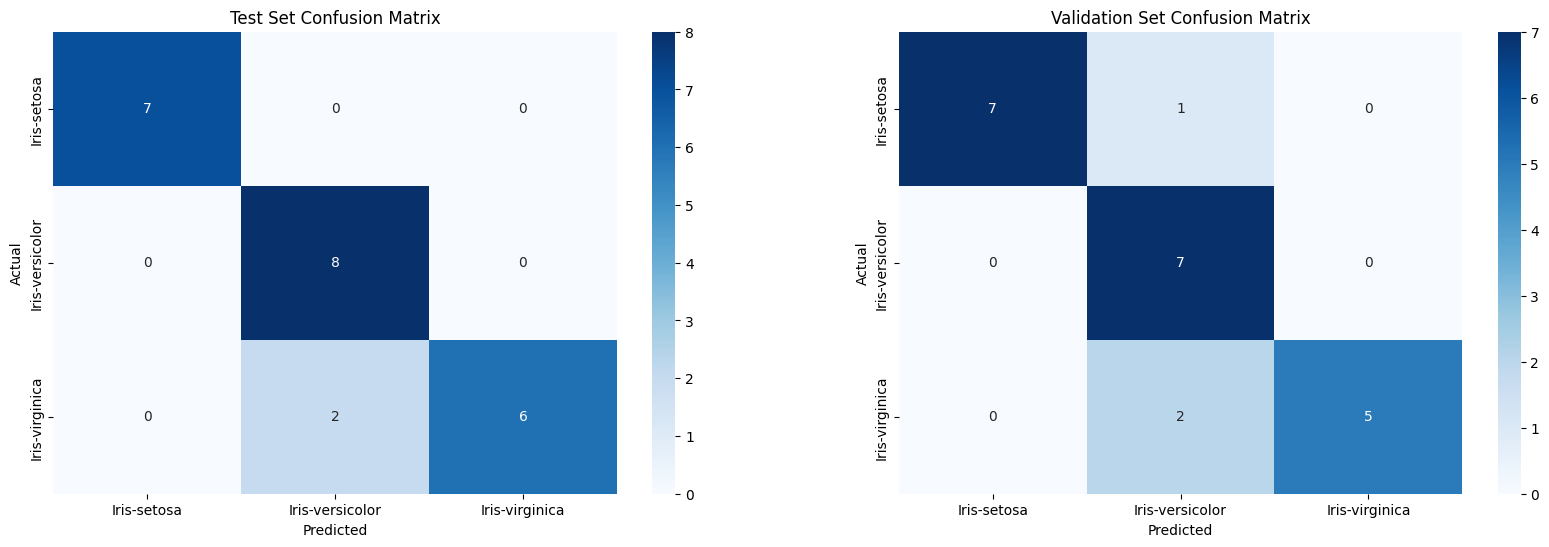

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for sklearn
y_test_np = y_test_tensor.numpy()
test_predicted_np = test_predicted.numpy()
y_val_np = y_val_tensor.numpy()
val_predicted_np = val_predicted.numpy()

# Define the class names
class_names = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]

# Classification Report for Test and Validation Sets
print("\nTest Set Classification Report:")
test_report = classification_report(y_test_np, test_predicted_np, target_names=class_names, output_dict=True)
print(classification_report(y_test_np, test_predicted_np, target_names=class_names))

print("\nValidation Set Classification Report:")
val_report = classification_report(y_val_np, val_predicted_np, target_names=class_names, output_dict=True)
print(classification_report(y_val_np, val_predicted_np, target_names=class_names))

# Convert classification reports to DataFrames
test_report_df = pd.DataFrame(test_report).transpose()
val_report_df = pd.DataFrame(val_report).transpose()

# Plot classification reports side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
test_report_df.iloc[:-1, :-1].plot(kind='bar', ax=axes[0])
axes[0].set_title('Test Set Classification Report')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Scores')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

val_report_df.iloc[:-1, :-1].plot(kind='bar', ax=axes[1])
axes[1].set_title('Validation Set Classification Report')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Scores')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.legend(loc='lower right')
plt.show()

# Confusion Matrix for Test and Validation Sets
print("\nTest Set Confusion Matrix:")
test_cm = confusion_matrix(y_test_np, test_predicted_np)
test_cm_display = pd.DataFrame(test_cm, index=class_names, columns=class_names)
print(test_cm_display)

print("\nValidation Set Confusion Matrix:")
val_cm = confusion_matrix(y_val_np, val_predicted_np)
val_cm_display = pd.DataFrame(val_cm, index=class_names, columns=class_names)
print(val_cm_display)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(test_cm_display, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Test Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(val_cm_display, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

## Saving the trained model

In [8]:
import os
current_time = time.strftime("%Y%m%d-%H%M%S")

# Create models folder
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model
file = f"models/iris_model_{current_time}_{hidden_size}_{num_epochs}_{val_accuracy * 100:.5f}.pth"
torch.save(model.state_dict(), file)

# Print out all important data related to the trained model (like time, epochs, accuracy, hidden size, learning rate, last loss function)
print(f'Model saved as {file}\n')

print(f'Info about the trained model at {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())}:')
print(f'Training Time: {training_time:.2f} seconds')
print(f'Number of Epochs: {final_epoch}/{num_epochs}')
print(f'Testing Accuracy: {test_accuracy * 100:.5f}%')
print(f'Validation Accuracy: {val_accuracy * 100:.5f}%')
print(f'Hidden Size: {model.fc1.out_features}')
print(f'Learning Rate Scheduler Gamma: {lr_scheduler_gamma}')
print(f'Starting Learning Rate: {optimizer.param_groups[0]["initial_lr"]}')
print(f'Final Learning Rate: {optimizer.param_groups[0]["lr"]}')
print(f'Last Training Loss Value: {train_loss_values[-1]:.4f}')
print(f'Best Training Loss: {min(train_loss_values):.4f} at epoch {train_loss_values.index(min(train_loss_values)) + 1}')
print(f'Last Validation Loss Value: {val_loss_values[-1]:.4f}')
print(f'Best Validation Loss: {min(val_loss_values):.4f} at epoch {val_loss_values.index(min(val_loss_values)) + 1}')


Model saved as models/iris_model_20241123-145518_128_300_86.36364.pth

Info about the trained model at 2024-11-23 14:55:18:
Training Time: 0.05 seconds
Number of Epochs: 23/300
Testing Accuracy: 91.30435%
Validation Accuracy: 86.36364%
Hidden Size: 128
Learning Rate Scheduler Gamma: 0.95
Starting Learning Rate: 0.01
Final Learning Rate: 0.0030735686772502355
Last Training Loss Value: 0.5664
Best Training Loss: 0.5654 at epoch 18
Last Validation Loss Value: 0.7329
Best Validation Loss: 0.7148 at epoch 18


# Reflection

It was a fun assignment, learning how to actually build a model, experimenting with the parameters, and changing different activation functions to try to optimize the network was cool.

Visualizing the loss functions and how they changed with different parameters, mainly the hidden size and the epoch count was satisfying.

One main fear I had was the model overfitting and constantly getting an accuracy of 100%, it tended to jump between 95.65217% and 100%, which was mainly just the difference of one iris-virginia being falsely predicted as iris-versicolor, or vice versa.

Learning more about how to split the data helped with more accurate results. I decided to test out having a validation set as well as a testing set. This helped with ensuring less overfitting was occurring. From what I've understood from researching is that 100% accuracy means there is overfitting, and so having the validation set be 95.45455% is a good thing, as it shows less overfitting with unseen data. Alongside this, the validation set also gave me the ability to use patience to do early stopping, in case there was no improvement over a specified number of epochs.

I did use ChatGPT for explanations and quick answers, as well as helping to pinpoint a good place to start with the project, along with actually researching for myself and checking out other code examples from people on Kaggle or GitHub, to help me get a better understanding of pytorch and how to actually structure a NN class.

Testing out different techniques such as Dropout, Batch nNrmalization, and LR Scheduling helped to decrease overfitting and lower the final loss of the training and validation sets. Without Batch Normalization for example the loss curve had lots of ups and downs, meaning lots of local minimums. Without Dropout the loss curve was much smoother, but there could be a higher chance of overfitting. Learning Rate Scheduling helped with optimizing the time taken and decreasing the epochs needed.

Overall this assignment was incredibly useful, interesting, and very helpful in actual practice training for building neural networks.
